In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import plotly.graph_objects as go
import plotly.express as px
import geopandas as gpd
import pycountry
from plotly.subplots import make_subplots
from scipy.stats import chi2_contingency

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

pd.options.display.max_columns = None  # 길어서 생략된 열 다 보이게 하기

In [2]:
distribution_centers = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/distribution_centers_optimized.parquet')
# events_file = pd.read_parquet('../dataset/Looker Ecommerce BigQuery Dataset/Optimization/events_optimized.parquet')
inventory_items = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/inventory_items_optimized.parquet')
orders = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/orders_optimized.parquet')
order_items = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/order_items_optimized.parquet')
products = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/products_optimized.parquet')
users = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/users_optimized.parquet') 
events1 = pd.read_parquet("/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/events_optimized_divided1.parquet")
events2 = pd.read_parquet("/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/events_optimized_divided2.parquet")
events = pd.concat([events1, events2]).sort_index()

In [3]:
orders_orderitems = pd.merge(order_items, orders,
                             left_on = ['order_id', 'user_id'],
                             right_on = ['order_id', 'user_id'],
                             how ='left',
                             suffixes=('_item', '_order'))
orders_orderitems.head()

,id,order_id,user_id,product_id,inventory_item_id,status_item,created_at_item,shipped_at_item,delivered_at_item,returned_at_item,sale_price,status_order,gender,created_at_order,returned_at_order,shipped_at_order,delivered_at_order,num_of_item
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,Cancelled,F,2023-05-07 07:33:00+00:00,NaT,NaT,NaT,1
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,Complete,F,2023-03-14 03:59:00+00:00,NaT,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,1
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,0.02,Complete,F,2023-12-03 13:23:00+00:00,NaT,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,4
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaT,NaT,0.02,Shipped,F,2023-12-23 00:17:00+00:00,NaT,2023-12-24 16:44:00+00:00,NaT,4
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,Shipped,F,2022-06-17 17:21:00+00:00,NaT,2022-06-19 19:29:00+00:00,NaT,3


In [4]:
orders_products = pd.merge(orders_orderitems, products,
                           left_on = ['product_id'],
                           right_on = ['id'],
                           how = 'left',
                           suffixes=('_orderproducts', '_products'))
orders_products

,id_orderproducts,order_id,user_id,product_id,inventory_item_id,status_item,created_at_item,shipped_at_item,delivered_at_item,returned_at_item,sale_price,status_order,gender,created_at_order,returned_at_order,shipped_at_order,delivered_at_order,num_of_item,id_products,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,Cancelled,F,2023-05-07 07:33:00+00:00,NaT,NaT,NaT,1,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,Complete,F,2023-03-14 03:59:00+00:00,NaT,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,1,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,0.02,Complete,F,2023-12-03 13:23:00+00:00,NaT,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,4,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaT,NaT,0.02,Shipped,F,2023-12-23 00:17:00+00:00,NaT,2023-12-24 16:44:00+00:00,NaT,4,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,Shipped,F,2022-06-17 17:21:00+00:00,NaT,2022-06-19 19:29:00+00:00,NaT,3,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181754,9674,6679,5325,24447,26095,Returned,2020-12-23 00:05:01+00:00,2020-12-25 22:54:00+00:00,2020-12-28 07:08:00+00:00,2020-12-30 22:43:00+00:00,999.00,Returned,M,2020-12-23 00:07:00+00:00,2020-12-30 22:43:00+00:00,2020-12-25 22:54:00+00:00,2020-12-28 07:08:00+00:00,1,24447,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5
181755,7801,5416,4283,24447,21078,Shipped,2022-01-12 23:51:07+00:00,2022-01-10 03:42:00+00:00,NaT,NaT,999.00,Shipped,M,2022-01-10 03:11:00+00:00,NaT,2022-01-10 03:42:00+00:00,NaT,3,24447,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5
181756,62986,43364,34691,23546,169937,Shipped,2023-02-26 00:38:43+00:00,2023-02-25 06:53:00+00:00,NaT,NaT,999.00,Shipped,M,2023-02-25 01:58:00+00:00,NaT,2023-02-25 06:53:00+00:00,NaT,3,23546,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,999.00,Men,C1AA157F9E8516370E3345F226EF62FC,5
181757,106577,73418,58623,24447,287560,Shipped,2023-11-12 02:41:02+00:00,2023-11-14 20:44:00+00:00,NaT,NaT,999.00,Shipped,M,2023-11-12 04:51:00+00:00,NaT,2023-11-14 20:44:00+00:00,NaT,1,24447,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5


In [5]:
all_order_data = pd.merge(orders_products, inventory_items,
                          left_on=['inventory_item_id'],
                          right_on=['id'],
                          how='left',
                          suffixes=('_all', '_items'))
all_order_data

,id_orderproducts,order_id,user_id,product_id_all,inventory_item_id,status_item,created_at_item,shipped_at_item,delivered_at_item,returned_at_item,sale_price,status_order,gender,created_at_order,returned_at_order,shipped_at_order,delivered_at_order,num_of_item,id_products,cost_all,category,name,brand,retail_price,department,sku,distribution_center_id,id,product_id_items,created_at,sold_at,cost_items,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,Cancelled,F,2023-05-07 07:33:00+00:00,NaT,NaT,NaT,1,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,410368,14235,2021-09-09 06:17:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,Complete,F,2023-03-14 03:59:00+00:00,NaT,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,1,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,110590,14235,2023-06-05 15:24:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,0.02,Complete,F,2023-12-03 13:23:00+00:00,NaT,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,4,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,138236,14235,2020-04-12 14:36:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaT,NaT,0.02,Shipped,F,2023-12-23 00:17:00+00:00,NaT,2023-12-24 16:44:00+00:00,NaT,4,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,99072,14235,2020-01-24 05:47:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,Shipped,F,2022-06-17 17:21:00+00:00,NaT,2022-06-19 19:29:00+00:00,NaT,3,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,353798,14235,2022-09-13 16:58:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181754,9674,6679,5325,24447,26095,Returned,2020-12-23 00:05:01+00:00,2020-12-25 22:54:00+00:00,2020-12-28 07:08:00+00:00,2020-12-30 22:43:00+00:00,999.00,Returned,M,2020-12-23 00:07:00+00:00,2020-12-30 22:43:00+00:00,2020-12-25 22:54:00+00:00,2020-12-28 07:08:00+00:00,1,24447,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5,26095,24447,2021-10-07 09:37:00+00:00,NaT,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5
181755,7801,5416,4283,24447,21078,Shipped,2022-01-12 23:51:07+00:00,2022-01-10 03:42:00+00:00,NaT,NaT,999.00,Shipped,M,2022-01-10 03:11:00+00:00,NaT,2022-01-10 03:42:00+00:00,NaT,3,24447,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5,21078,24447,2023-09-16 00:38:00+00:00,NaT,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5
18

In [6]:
all_order_data = pd.merge(all_order_data, users,
                          left_on =['user_id'],
                          right_on=['id'],
                          how='left',
                          suffixes=('_orders', '_user'))
all_order_data

,id_orderproducts,order_id,user_id,product_id_all,inventory_item_id,status_item,created_at_item,shipped_at_item,delivered_at_item,returned_at_item,sale_price,status_order,gender_orders,created_at_order,returned_at_order,shipped_at_order,delivered_at_order,num_of_item,id_products,cost_all,category,name,brand,retail_price,department,sku,distribution_center_id,id_orders,product_id_items,created_at_orders,sold_at,cost_items,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id,id_user,first_name,last_name,email,age,gender_user,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at_user
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,Cancelled,F,2023-05-07 07:33:00+00:00,NaT,NaT,NaT,1,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,410368,14235,2021-09-09 06:17:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,83582,Kathryn,Ortega,kathrynortega@example.net,29,F,Hebei,3863 Johnson Brooks Suite 474,74199,Jinhua,China,39.388173,115.731465,Search,2021-11-27 07:33:00+00:00
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,Complete,F,2023-03-14 03:59:00+00:00,NaT,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,1,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,110590,14235,2023-06-05 15:24:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,22551,Terri,Alvarez,terrialvarez@example.net,35,F,Jiangsu,5374 Courtney Parkway,215007,Yulin,China,31.278607,120.642997,Organic,2022-07-15 03:59:00+00:00
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,0.02,Complete,F,2023-12-03 13:23:00+00:00,NaT,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,4,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,138236,14235,2020-04-12 14:36:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,28215,Rebecca,Mcgee,rebeccamcgee@example.org,49,F,Texas,7187 Michael Forge Apt. 777,75604,Longview,United States,32.512434,-94.825486,Organic,2019-06-22 13:23:00+00:00
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaT,NaT,0.02,Shipped,F,2023-12-23 00:17:00+00:00,NaT,2023-12-24 16:44:00+00:00,NaT,4,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,99072,14235,2020-01-24 05:47:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,20165,Shelly,Rogers,shellyrogers@example.net,44,F,Hyogo,6970 Cherry Extension Apt. 442,675-0137,Kakogawa City,Japan,34.718505,134.825010,Search,2022-05-17 00:17:00+00:00
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,Shipped,F,2022-06-17 17:21:00+00:00,NaT,2022-06-19 19:29:00+00:00,NaT,3,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,353798,14235,2022-09-13 16:58:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,71954,Mariah,Stephens,mariahstephens@example.com,59,F,England,6522 Stephens Meadows Suite 475,LA1,Lancaster,United Kingdom,54.045973,-2.794106,Search,2021-06-23 17:21:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [7]:
cancelled_orders = all_order_data[all_order_data['status_item'] == 'Cancelled'].copy()
returned_orders = all_order_data[all_order_data['status_item'] == 'Returned'].copy()
complete_orders = all_order_data[all_order_data['status_item'].isin(['Complete', 'Shipped'])].copy()

In [8]:
nums_of_brand = all_order_data['brand'].nunique()
nums_of_product = all_order_data['product_id_all'].nunique()
nums_of_category = all_order_data['category'].nunique()
print(f"브랜드 수 :", nums_of_brand)
print(f"제품 id 수 :", nums_of_product)
print(f"카테고리 수 :", nums_of_category)

브랜드 수 : 2752
제품 id 수 : 29046
카테고리 수 : 26


In [9]:
all_order_data

,id_orderproducts,order_id,user_id,product_id_all,inventory_item_id,status_item,created_at_item,shipped_at_item,delivered_at_item,returned_at_item,sale_price,status_order,gender_orders,created_at_order,returned_at_order,shipped_at_order,delivered_at_order,num_of_item,id_products,cost_all,category,name,brand,retail_price,department,sku,distribution_center_id,id_orders,product_id_items,created_at_orders,sold_at,cost_items,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id,id_user,first_name,last_name,email,age,gender_user,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at_user
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,Cancelled,F,2023-05-07 07:33:00+00:00,NaT,NaT,NaT,1,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,410368,14235,2021-09-09 06:17:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,83582,Kathryn,Ortega,kathrynortega@example.net,29,F,Hebei,3863 Johnson Brooks Suite 474,74199,Jinhua,China,39.388173,115.731465,Search,2021-11-27 07:33:00+00:00
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,Complete,F,2023-03-14 03:59:00+00:00,NaT,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,1,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,110590,14235,2023-06-05 15:24:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,22551,Terri,Alvarez,terrialvarez@example.net,35,F,Jiangsu,5374 Courtney Parkway,215007,Yulin,China,31.278607,120.642997,Organic,2022-07-15 03:59:00+00:00
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,0.02,Complete,F,2023-12-03 13:23:00+00:00,NaT,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,4,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,138236,14235,2020-04-12 14:36:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,28215,Rebecca,Mcgee,rebeccamcgee@example.org,49,F,Texas,7187 Michael Forge Apt. 777,75604,Longview,United States,32.512434,-94.825486,Organic,2019-06-22 13:23:00+00:00
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaT,NaT,0.02,Shipped,F,2023-12-23 00:17:00+00:00,NaT,2023-12-24 16:44:00+00:00,NaT,4,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,99072,14235,2020-01-24 05:47:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,20165,Shelly,Rogers,shellyrogers@example.net,44,F,Hyogo,6970 Cherry Extension Apt. 442,675-0137,Kakogawa City,Japan,34.718505,134.825010,Search,2022-05-17 00:17:00+00:00
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,Shipped,F,2022-06-17 17:21:00+00:00,NaT,2022-06-19 19:29:00+00:00,NaT,3,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,353798,14235,2022-09-13 16:58:00+00:00,NaT,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,71954,Mariah,Stephens,mariahstephens@example.com,59,F,England,6522 Stephens Meadows Suite 475,LA1,Lancaster,United Kingdom,54.045973,-2.794106,Search,2021-06-23 17:21:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [10]:
# all_order_complete_data = all_order_data.loc[
#     (all_order_data['status_item'] == 'Complete') |
#     (all_order_data['status_item'] =='Processing') |
#     (all_order_data['status_item'] =='Shipped')
# ].copy()
# all_order_complete_data

In [11]:
orders_merged = pd.merge(order_items, products, left_on ='product_id', right_on ='id', how='left')

order_subset = orders[['order_id','user_id', 'num_of_item']]

orders_merged = pd.merge(orders_merged, order_subset, on=['order_id', 'user_id'], how='left')

orders_merged['profit'] = orders_merged['sale_price'] - orders_merged['cost']

# date 컬럼 포멧
orders_merged[['created_at', 'shipped_at', 'delivered_at']] =\
orders_merged[['created_at', 'shipped_at', 'delivered_at']].apply(lambda col: pd.to_datetime(col, errors='coerce', format='mixed'))
orders_merged

# processing, shipped 까지 complete로 넣음
orders_complete_merged = orders_merged.loc[
    (orders_merged['status'] == 'Complete') |
    (orders_merged['status'] =='Processing') |
    (orders_merged['status'] =='Shipped')
].copy()
orders_complete_merged

,id_x,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,id_y,cost,category,name,brand,retail_price,department,sku,distribution_center_id,num_of_item,profit
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,1,0.011700
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,0.02,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,4,0.011700
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaT,NaT,0.02,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,4,0.011700
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,3,0.011700
5,154022,106052,84693,14235,415780,Shipped,2023-09-19 09:13:08+00:00,2023-09-16 09:24:00+00:00,NaT,NaT,0.02,14235,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,2,0.011700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181753,51581,35450,28392,23546,139190,Processing,2023-10-24 18:42:24+00:00,NaT,NaT,NaT,999.00,23546,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,999.00,Men,C1AA157F9E8516370E3345F226EF62FC,5,4,516.483001
181755,7801,5416,4283,24447,21078,Shipped,2022-01-12 23:51:07+00:00,2022-01-10 03:42:00+00:00,NaT,NaT,999.00,24447,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5,3,594.404999
181756,62986,43364,34691,23546,169937,Shipped,2023-02-26 00:38:43+00:00,2023-02-25 06:53:00+00:00,NaT,NaT,999.00,23546,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,999.00,Men,C1AA157F9E8516370E3345F226EF62FC,5,3,516.483001
181757,106577,73418,58623,24447,287560,Shipped,2023-11-12 02:41:02+00:00,2023-11-14 20:44:00+00:00,NaT,NaT,999.00,24447,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5,1,594.404999


# 총 매출, 비용, 수익, 마진율

In [12]:
def calcaulate_summary(orders_complete_merged):
    total_revenue = round(orders_complete_merged['sale_price'].sum(), 2)
    total_cost = round(orders_complete_merged['cost'].sum(), 2)
    total_profit = round(orders_complete_merged['profit'].sum(), 2)
    total_margin_rate = ((total_revenue - total_cost) / total_cost) * 100

    summary_df = pd.DataFrame({
        'total_revenue': [total_revenue],
        'total_cost': [total_cost],
        'total_profit': [total_profit],
        'total_margin_rate': [total_margin_rate]
    })
    return summary_df

summary_df = calcaulate_summary(orders_complete_merged)
summary_df

,total_revenue,total_cost,total_profit,total_margin_rate
0,8127336.72,3909959.62,4217377.1,107.862421


# 브랜드 / 카테고리 / 제품id 매출액 순위 및 전체 매출 기여도

## 브랜드 별 수익-매출-비용

In [13]:
brand_performance = orders_complete_merged.groupby('brand')[['profit', 'sale_price', 'cost']].sum().reset_index()
top_performers = brand_performance.sort_values(by='sale_price', ascending=False).head(10)

print(top_performers)

                  brand        profit     sale_price          cost
447        Calvin Klein  82242.115855  154952.610408  72710.494553
701              Diesel  76431.100894  153819.549881  77388.448987
29    7 For All Mankind  67614.437061  140861.490417  73247.053357
465            Carhartt  74899.452825  140738.029172  65838.576347
2490      True Religion  63935.660840  134265.899741  70330.238901
2447     Tommy Hilfiger  52938.093481   96610.980059  43672.886578
2399     The North Face  45849.714014   83943.830109  38094.116094
2587             Volcom  38387.239193   78578.739820  40191.500627
1943         Quiksilver  35451.728262   76960.600072  41508.871810
567            Columbia  41758.452348   76706.879794  34948.427446


/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_7596/2739937997.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  brand_performance = orders_complete_merged.groupby('brand')[['profit', 'sale_price', 'cost']].sum().reset_index()


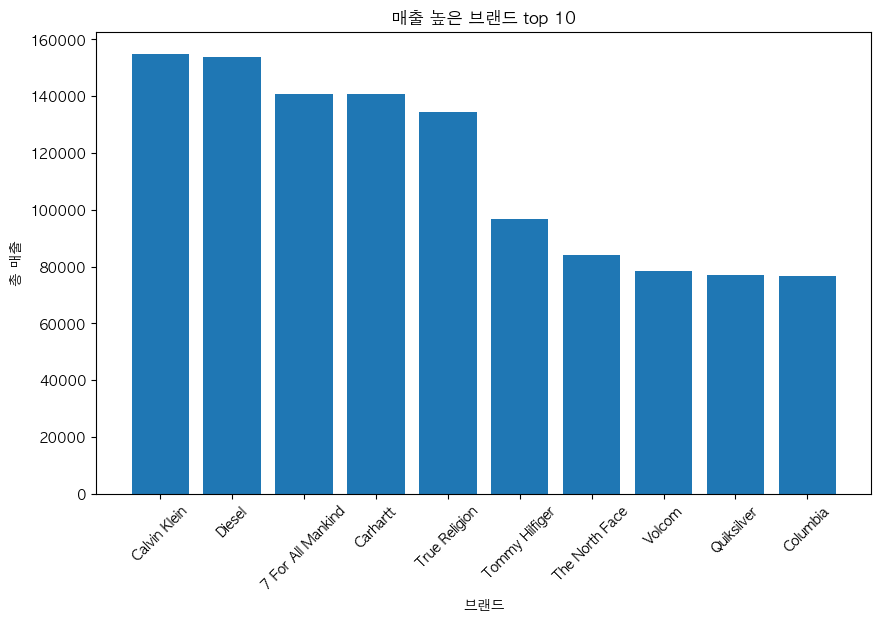

In [14]:
# top performers 시각화

plt.figure(figsize=(10,6))
plt.bar(top_performers['brand'], top_performers['sale_price'])
plt.xlabel('브랜드')
plt.ylabel('총 매출')
plt.xticks(rotation=45)
plt.title('매출 높은 브랜드 top 10')
plt.show()

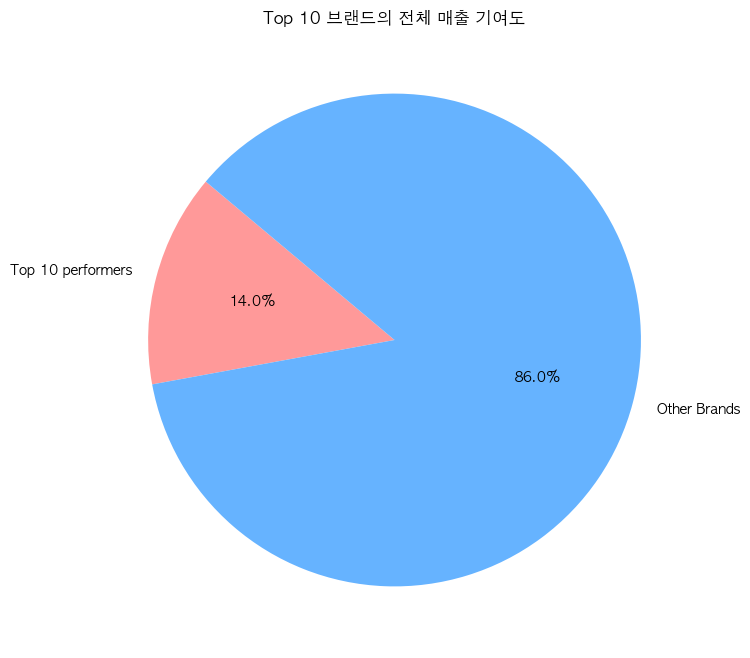

In [15]:
total_top_performers_profit = top_performers['sale_price'].sum()

top_performers_brands = top_performers['brand'].tolist()
other_company_profits = orders_complete_merged.loc[~orders_complete_merged['brand'].isin(top_performers_brands), 'sale_price'].sum()
combined_top_performers = pd.DataFrame({'brand':['Top 10 performers', 'Other Brands'], 'sales' : [total_top_performers_profit, other_company_profits]})


# 시각화
labels = combined_top_performers['brand']
sizes = combined_top_performers['sales']

colors = ['#ff9999','#66b3ff']

# 파이 차트 생성
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 브랜드의 전체 매출 기여도')
plt.show()


## 카테고리 별 수익-매출-비용

In [69]:
category_performance = orders_complete_merged.groupby('category')[['profit', 'sale_price', 'cost']].sum().reset_index()
top_cat_performers = category_performance.sort_values(by='sale_price', ascending=False).head()

print(top_cat_performers)

                         category         profit     sale_price           cost
11              Outerwear & Coats  545698.966501  983391.899374  437692.932873
7                           Jeans  437515.226906  941800.611532  504285.384626
22                       Sweaters  330424.016536  637020.430201  306596.413664
21            Suits & Sport Coats  297924.553950  497929.799460  200005.245510
5   Fashion Hoodies & Sweatshirts  234634.394687  488461.310351  253826.915664
23                           Swim  236333.333548  483074.140558  246740.807010
17                 Sleep & Lounge  209958.511985  408091.291099  198132.779114
15                         Shorts  188941.315295  378403.491210  189462.175914
24                    Tops & Tees  162508.473686  369301.621208  206793.147523
4                         Dresses  192069.683846  349628.690837  157559.006991


/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_7596/3927753076.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_performance = orders_complete_merged.groupby('category')[['profit', 'sale_price', 'cost']].sum().reset_index()


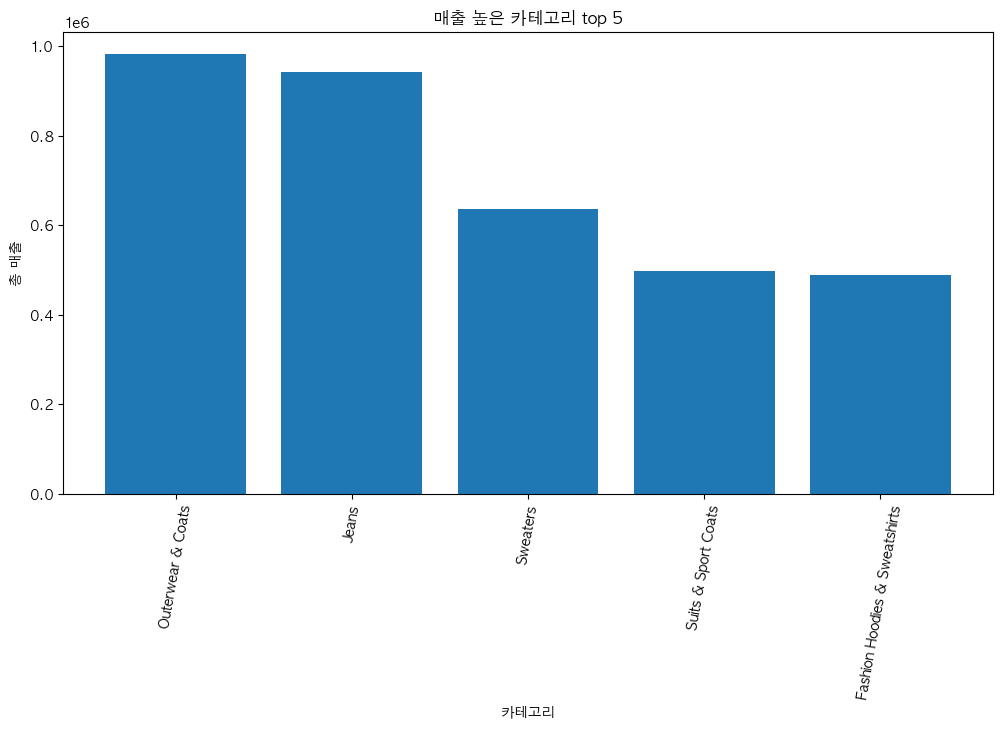

In [17]:
# top_cat_performers 시각화 

plt.figure(figsize=(12,6))
plt.bar(top_cat_performers['category'], top_cat_performers['sale_price'])
plt.xlabel('카테고리')
plt.ylabel('총 매출')
plt.xticks(rotation=80)
plt.title('매출 높은 카테고리 top 5')
plt.show()

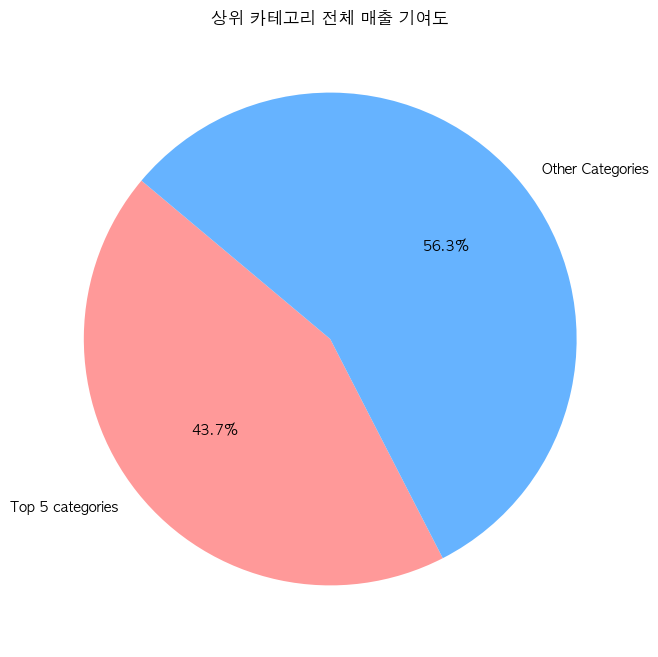

In [18]:
total_top_category_performance = top_cat_performers['sale_price'].sum()

top_cat_performers_list = top_cat_performers['category'].tolist()
other_cat_performance = orders_complete_merged.loc[~orders_complete_merged['category'].isin(top_cat_performers_list), 'sale_price'].sum()
combined_top_cat_performers = pd.DataFrame({'category': ['Top 5 categories', 'Other Categories'], 'sales': [total_top_category_performance, other_cat_performance]})


# 시각화
labels = combined_top_cat_performers['category']
sizes = combined_top_cat_performers['sales']

colors = ['#ff9999','#66b3ff']

# 파이 차트 생성
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('상위 카테고리 전체 매출 기여도')
plt.show()


In [19]:
orders_complete_merged.groupby('category')['product_id'].nunique().sort_values(ascending=False)

## top 5 카테고리의 매출이 높을 수 밖에 없는 이유 중 하나로, 카테고리 내 상품수가 많음
### 예외. 가장 상품을 많이 보유한 intimates 는 매출 top 10에 안들음 

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_7596/3258692296.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  orders_complete_merged.groupby('category')['product_id'].nunique().sort_values(ascending=False)


category
Intimates                        2331
Jeans                            1986
Tops & Tees                      1850
Fashion Hoodies & Sweatshirts    1847
Swim                             1776
Sleep & Lounge                   1760
Shorts                           1744
Sweaters                         1725
Accessories                      1548
Active                           1418
Outerwear & Coats                1408
Underwear                        1083
Pants                            1034
Dresses                           934
Socks                             899
Maternity                         895
Plus                              747
Suits & Sport Coats               731
Socks & Hosiery                   655
Pants & Capris                    607
Leggings                          555
Blazers & Jackets                 554
Skirts                            356
Suits                             188
Jumpsuits & Rompers               159
Clothing Sets                      36
Nam

In [25]:
orders_complete_merged[orders_complete_merged['category']=='Intimates']

,id_x,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,id_y,cost,category,name,brand,retail_price,department,sku,distribution_center_id,num_of_item,profit
31,35882,24703,19697,12536,96821,Complete,2023-11-23 04:34:36+00:00,2023-11-23 09:20:00+00:00,2023-11-24 03:24:00+00:00,NaT,1.75,12536,1.01325,Intimates,Individual Bra Extenders,Extenders,1.75,Women,359499F804EA7988921BF86C9377FB95,4,1,0.73675
32,112748,77696,62002,12536,304194,Complete,2024-01-17 03:54:46.754527+00:00,2024-01-15 10:04:24.754527+00:00,2024-01-19 05:05:24.754527+00:00,NaT,1.75,12536,1.01325,Intimates,Individual Bra Extenders,Extenders,1.75,Women,359499F804EA7988921BF86C9377FB95,4,2,0.73675
33,117438,80895,64513,12536,316927,Processing,2023-11-04 05:25:47+00:00,NaT,NaT,NaT,1.75,12536,1.01325,Intimates,Individual Bra Extenders,Extenders,1.75,Women,359499F804EA7988921BF86C9377FB95,4,2,0.73675
34,166143,114444,91424,12536,448518,Processing,2021-11-19 13:59:16+00:00,NaT,NaT,NaT,1.75,12536,1.01325,Intimates,Individual Bra Extenders,Extenders,1.75,Women,359499F804EA7988921BF86C9377FB95,4,2,0.73675
180,22591,15634,12504,12265,60963,Complete,2020-12-31 01:09:44+00:00,2020-12-31 17:17:00+00:00,2021-01-04 06:13:00+00:00,NaT,2.99,12265,1.62357,Intimates,Alivila.Y Fashion Sexy Lace & Sheer Net Linger...,Alivila.Y Fashion,2.99,Women,2B3E69A7084C76E56BE15598FC72DED6,1,1,1.36643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181617,81244,55905,44773,10453,219250,Complete,2022-10-08 05:28:26+00:00,2022-10-08 14:48:00+00:00,2022-10-10 18:18:00+00:00,NaT,903.00,10453,512.00100,Intimates,NIKE WOMEN'S PRO COMPRESSION SPORTS BRA *Outst...,Nike,903.00,Women,4801441F041958AFACA324C43C40787B,7,3,390.99900
181628,135711,93409,74506,10453,366366,Complete,2023-07-04 02:56:16+00:00,2023-07-04 11:08:00+00:00,2023-07-07 04:41:00+00:00,NaT,903.00,10453,512.00100,Intimates,NIKE WOMEN'S PRO COMPRESSION SPORTS BRA *Outst...,Nike,903.00,Women,4801441F041958AFACA324C43C40787B,7,4,390.99900
181637,180571,124384,99342,10453,487550,Complete,2023-08-04 07:18:00+00:00,2023-08-05 10:41:00+00:00,2023-08-10 05:21:00+00:00,NaT,903.00,10453,512.00100,Intimates,NIKE WOMEN'S PRO COMPRESSION SPORTS BRA *Outst...,Nike,903.00,Women,4801441F041958AFACA324C43C40787B,7,1,390.99900
181664,169722,116895,93371,10453,458228,Processing,2023-08-30 07:41:12+00:00,NaT,NaT,NaT,903.00,10453,512.00100,Intimates,NIKE WOMEN'S PRO COMPRESSION SPORTS BRA *Outst...,Nike,903.00,Women,4801441F041958AFACA324C43C40787B,7,2,390.99900


In [20]:
product_count_per_category_brand = orders_complete_merged.groupby(['category', 'brand'])['product_id'].nunique()
product_count_per_category_brand = product_count_per_category_brand[product_count_per_category_brand != 0]
product_count_per_category_brand


/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_7596/3164512808.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_count_per_category_brand = orders_complete_merged.groupby(['category', 'brand'])['product_id'].nunique()


category     brand                  
Accessories  106Shades                   5
             180s                       15
             A:X Armani Exchange         2
             ALL BLACK                   1
             AN1225                      2
                                        ..
Underwear    Wolverine                   6
             Wrangler                    2
             YogaColors                  2
             Zimmerli of Switzerland     2
             bioworld                    3
Name: product_id, Length: 5821, dtype: int64

## 매출 높은 상위 브랜드들의 카테고리 속 비중 확인

In [21]:
# 매출이 높은 상위 브랜드들의 카테고리 속 비중 구하기
top_performers_brands = top_performers['brand'].tolist()

# 매출이 높은 상위 브랜드들의 매출
top_performers_sales = brand_performance[brand_performance['brand'].isin(top_performers_brands)]['sale_price'].sum()

# 카테고리별 매출
category_sales = orders_complete_merged.groupby('category')['sale_price'].sum()

# 상위 브랜드들이 속한 카테고리의 비중 계산
category_sales_top_brands = orders_complete_merged[orders_complete_merged['brand'].isin(top_performers_brands)].groupby('category')['sale_price'].sum()

# 카테고리별 매출 중 매출이 높은 상위 브랜드들의 비중
category_sales_top_brands_ratio = (category_sales_top_brands / category_sales).sort_values(ascending=False).reset_index(name='ratio')

print(category_sales_top_brands_ratio)

                         category     ratio
0                           Jeans  0.339398
1               Outerwear & Coats  0.252608
2                          Shorts  0.181516
3                       Underwear  0.170914
4             Suits & Sport Coats  0.154417
5                     Tops & Tees  0.146426
6   Fashion Hoodies & Sweatshirts  0.130731
7                          Active  0.122744
8                           Pants  0.121194
9                            Swim  0.111859
10                       Sweaters  0.093237
11                 Pants & Capris  0.085577
12                          Socks  0.048217
13                    Accessories  0.047264
14                        Dresses  0.041668
15                           Plus  0.039918
16                         Skirts  0.034243
17                  Clothing Sets  0.034146
18                 Sleep & Lounge  0.032695
19                       Leggings  0.027841
20              Blazers & Jackets  0.024856
21                Socks & Hosier

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_7596/1835715465.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_sales = orders_complete_merged.groupby('category')['sale_price'].sum()
/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_7596/1835715465.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_sales_top_brands = orders_complete_merged[orders_complete_merged['brand'].isin(top_performers_brands)].groupby('category')['sale_price'].sum()


In [22]:
# 매출이 높은 상위 브랜드들의 카테고리 속 비중 구하기
top_performers_brands = top_performers['brand'].tolist()

# 매출이 높은 상위 브랜드들의 매출
top_performers_sales = brand_performance[brand_performance['brand'].isin(top_performers_brands)]['sale_price'].sum()

# 카테고리별 매출
category_sales = orders_complete_merged.groupby('category')['sale_price'].sum()

# 상위 브랜드들이 속한 카테고리의 비중 계산
category_sales_top_brands = orders_complete_merged[orders_complete_merged['brand'].isin(top_performers_brands)].groupby(['category', 'brand'])['sale_price'].sum().reset_index()

# 카테고리별 매출 중 매출이 높은 상위 브랜드들의 비중
category_sales_top_brands_ratio = pd.merge(category_sales_top_brands, category_sales.reset_index(), on='category', suffixes=('_brand', '_category'))
category_sales_top_brands_ratio['ratio'] = category_sales_top_brands_ratio['sale_price_brand'] / category_sales_top_brands_ratio['sale_price_category']
category_sales_top_brands_ratio = category_sales_top_brands_ratio.sort_values(by='ratio', ascending=False)
category_sales_top_brands_ratio


/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_7596/1664010775.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_sales = orders_complete_merged.groupby('category')['sale_price'].sum()
/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_7596/1664010775.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_sales_top_brands = orders_complete_merged[orders_complete_merged['brand'].isin(top_performers_brands)].groupby(['category', 'brand'])['sale_price'].sum().reset_index()


,category,brand,sale_price_brand,sale_price_category,ratio
19321,Jeans,7 For All Mankind,116218.830368,941800.611532,0.123401
69347,Underwear,Calvin Klein,15041.240026,153831.490208,0.097777
21782,Jeans,True Religion,90072.390160,941800.611532,0.095638
19993,Jeans,Diesel,87363.279877,941800.611532,0.092762
30781,Outerwear & Coats,Carhartt,76729.779251,983391.899374,0.078026
...,...,...,...,...,...
23912,Jumpsuits & Rompers,Pepsi,0.000000,30430.950119,0.000000
23913,Jumpsuits & Rompers,Perry,0.000000,30430.950119,0.000000
23914,Jumpsuits & Rompers,Perry Ellis,0.000000,30430.950119,0.000000
23915,Jumpsuits & Rompers,Persol,0.000000,30430.950119,0.000000


In [23]:
# 데이터프레임에서 상위 브랜드들의 비중이 0인 행 제외
filtered_df = category_sales_top_brands_ratio[category_sales_top_brands_ratio['ratio'] > 0]

# for category, group in filtered_df.groupby('category'):
#     plt.figure(figsize=(8, 6))
#     plt.pie(group['ratio'], labels=group['brand'], autopct='%1.1f%%', startangle=140)
#     plt.title(f'{category} Category Sales Ratio of Top Brands')
#     plt.axis('equal')  # 원 그래프를 원형으로 유지
#     plt.show()

### 필터링 안된 범위에서 비율 구하는 건 실패함... 

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_7596/3559661064.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (category, data) in enumerate(filtered_df.groupby('category')):


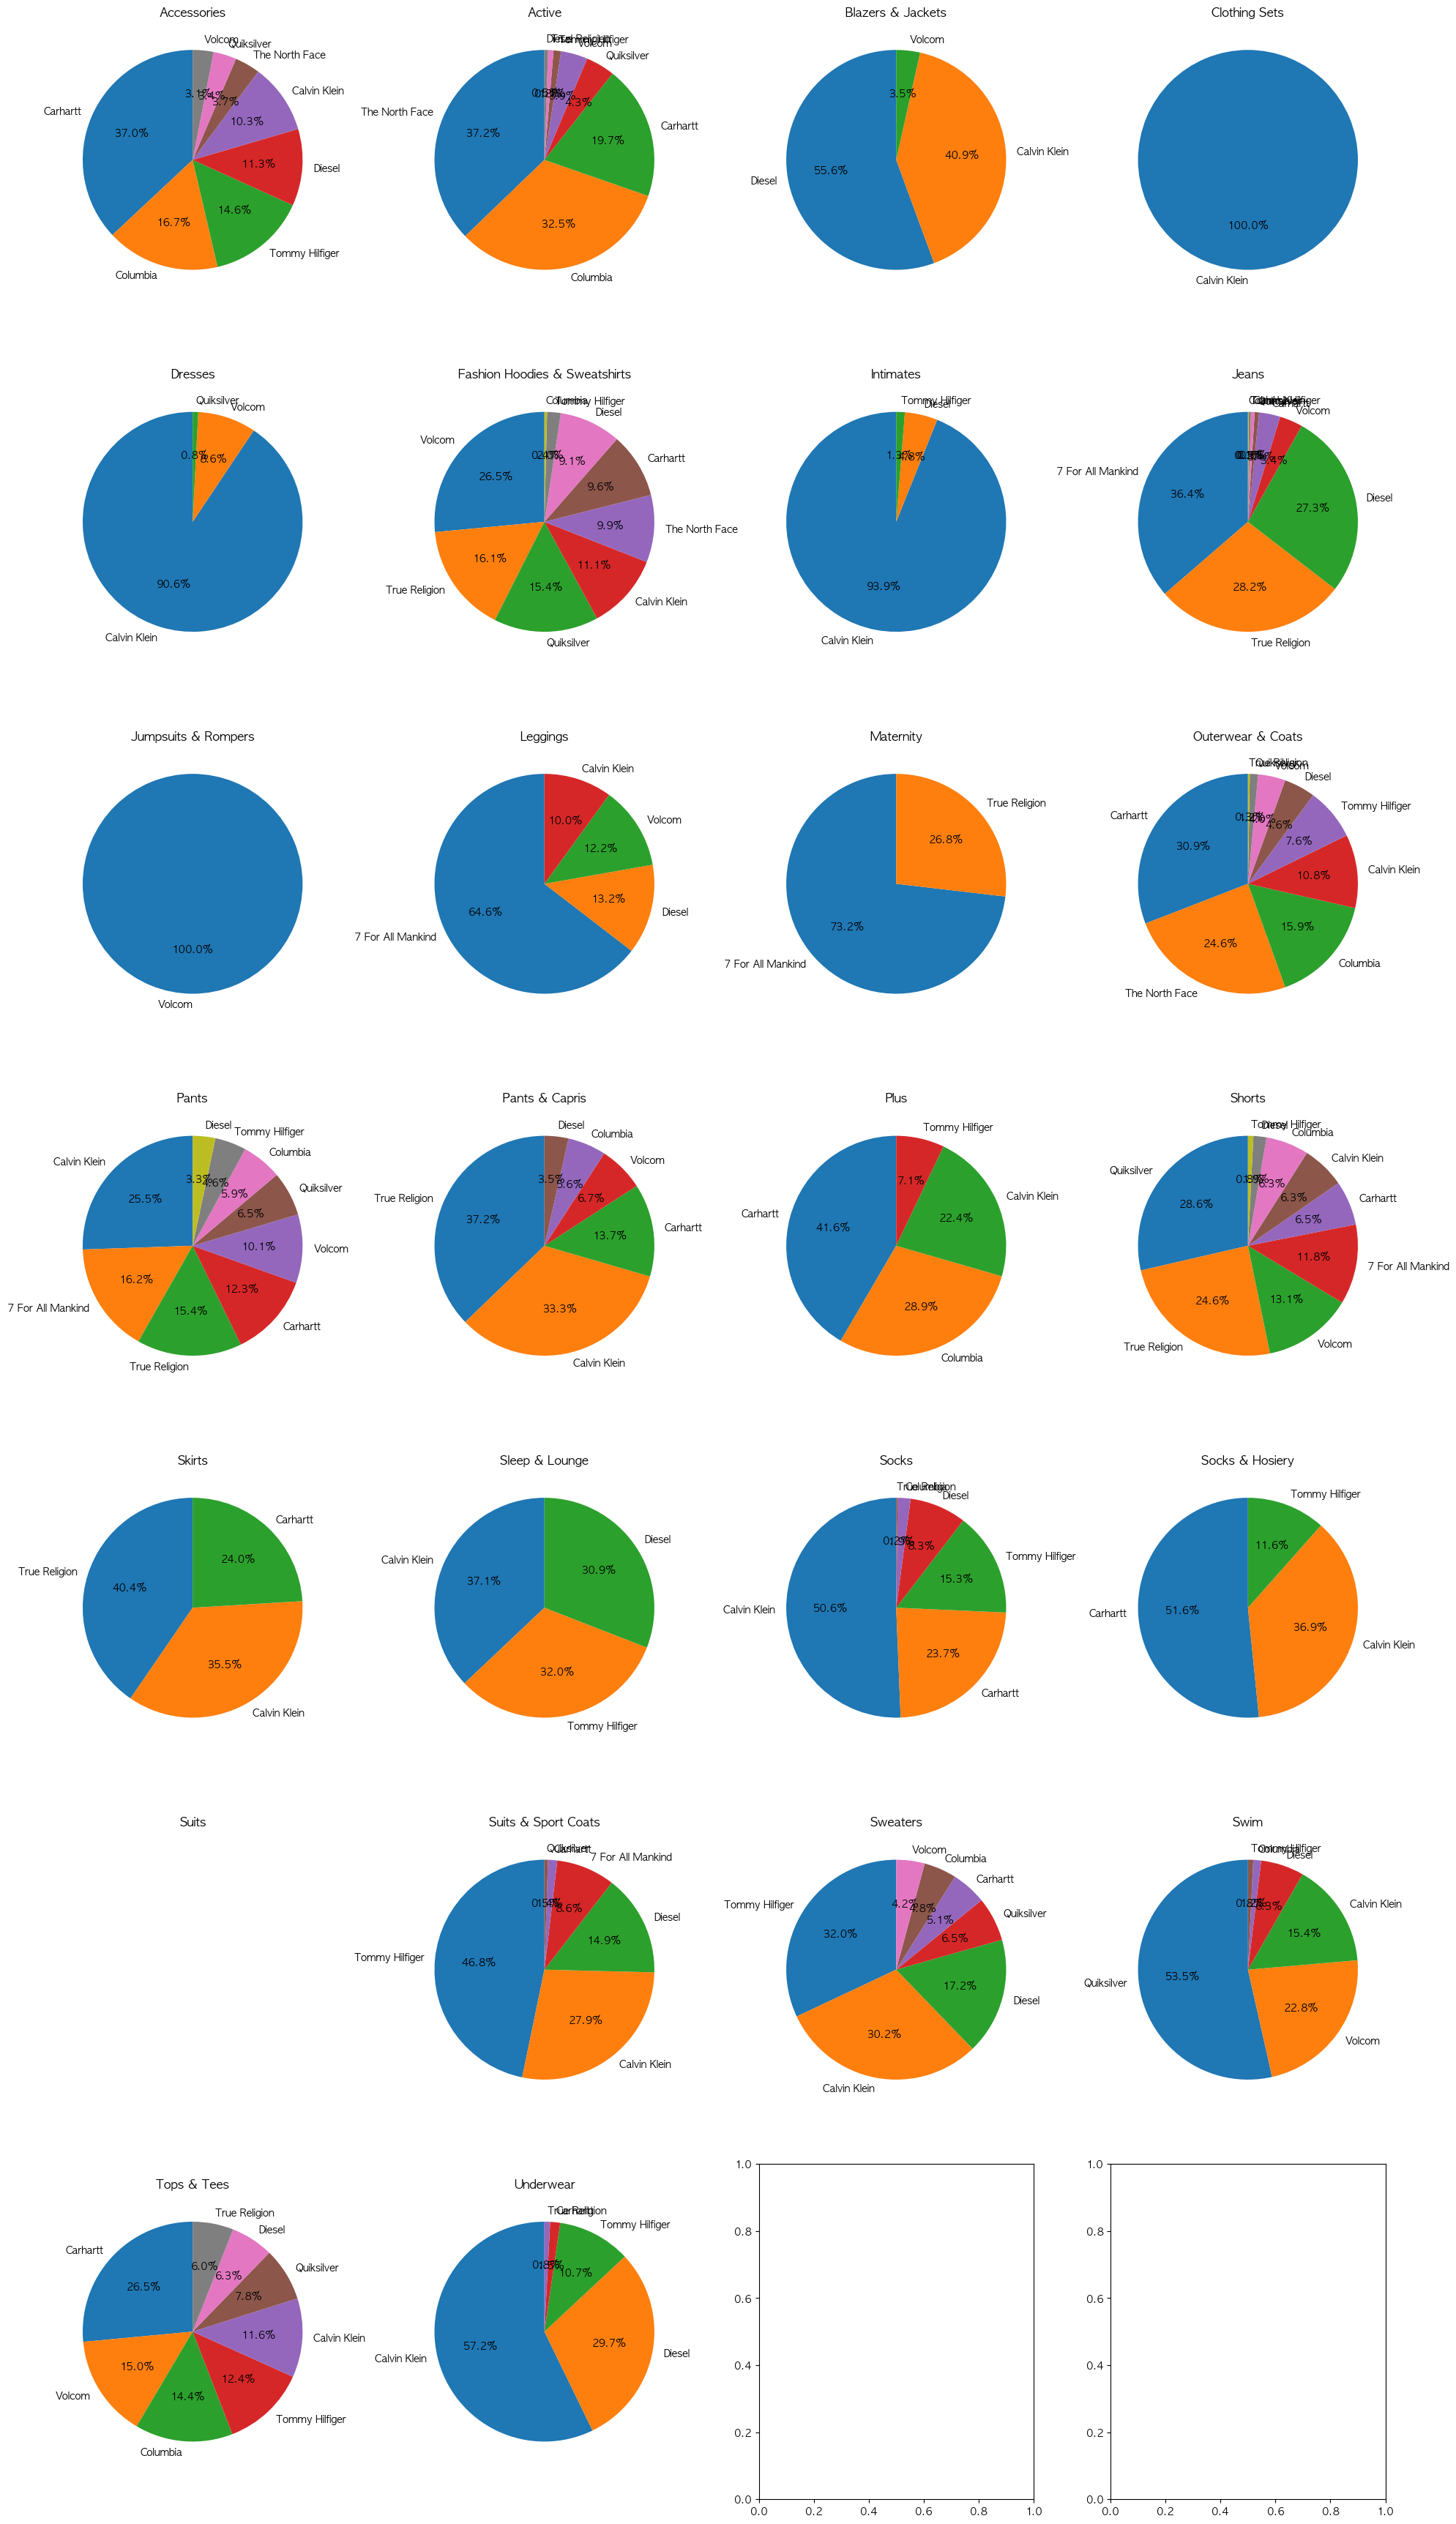

In [34]:

# 카테고리별 원그래프 subplot 그리기
num_categories = len(filtered_df['category'].unique())
num_rows = (num_categories + 3) // 4  # 올림 계산

fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5*num_rows))

for i, (category, data) in enumerate(filtered_df.groupby('category')):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.pie(data['ratio'], labels=data['brand'], autopct='%1.1f%%', startangle=90)
    ax.set_title(category)

plt.tight_layout()
plt.show()

# 전체 카테고리 내 브랜드 비율  ->> 실패
# num_categories = len(category_sales_top_brands_ratio['category'].unique())
# num_rows = (num_categories + 3) // 4  # 올림 계산

# fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5*num_rows))

# for i, (category, data) in enumerate(category_sales_top_brands_ratio.groupby('category')):
#     row = i // 4
#     col = i % 4
#     ax = axes[row, col]
#     ax.pie(data['ratio'].fillna(0), labels=data['brand'], autopct='%1.1f%%', startangle=90)
#     ax.pie(data['ratio'], labels=data['brand'], autopct=lambda x: f'{x:.1f}%' if x > 0 else '', startangle=90)
#     ax.set_title(category)

# plt.tight_layout()
# plt.show()


In [ ]:
# # Define a custom autopct function to adjust label positions
# def autopct_format(values):
#     def my_autopct(pct):
#         total = sum(values)
#         val = int(round(pct*total/100))
#         return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)
#     return my_autopct

# # 카테고리별 원그래프 subplot 그리기
# num_categories = len(filtered_df['category'].unique())
# num_cols = min(num_categories, 3)
# num_rows = (num_categories + 2) // 3  # 올림 계산

# fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15*num_cols, 5*num_rows))

# for i, (category, data) in enumerate(filtered_df.groupby('category')):
#     ax = axes[i // num_cols, i % num_cols]
#     ax.pie(data['ratio'], labels=data['brand'], autopct=autopct_format(data['ratio']), startangle=90)
#     ax.set_title(category)

# plt.tight_layout()
# plt.show()


In [ ]:
# # 카테고리별 원그래프 subplot 그리기
# num_categories = len(filtered_df['category'].unique())
# num_cols = min(num_categories, 3)
# num_rows = (num_categories + 2) // 3  # 올림 계산

# fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15*num_cols, 5*num_rows))

# for i, (category, data) in enumerate(filtered_df.groupby('category')):
#     ax = axes[i // num_cols, i % num_cols]
#     ax.pie(data['ratio'], labels=data['brand'], startangle=90)

#     # annotation을 사용하여 텍스트 배치
#     total = data['ratio'].sum()
#     ypos = 0
#     for j, (brand, ratio) in enumerate(zip(data['brand'], data['ratio'])):
#         angle = 360 * (ypos + ratio / 2) / total
#         ax.annotate('{:.1f}%'.format(ratio), xy=(0, 0), xytext=(1.3, ypos), textcoords='data', ha='center', va='center', fontsize=10)
#         ypos += ratio

#     ax.set_title(category)

# plt.tight_layout()
# plt.show()


## 카테고리 - 제품이름 별 주문수량

In [68]:
popular_products = orders_complete_merged.groupby(['category', 'name'])['num_of_item'].sum().reset_index()
popular_products_except_jeans = orders_complete_merged.query("category != 'Jeans'").groupby(['category', 'name'])['num_of_item'].sum().reset_index()
top_20_products = popular_products.sort_values(by='num_of_item', ascending=False).head(20)
top_20_products_ex_jeans = popular_products_except_jeans.sort_values(by='num_of_item', ascending=False).head(20)

top_20_products_ex_jeans

## 청바지 제외하고도 확인 !!!! 

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_7596/776910907.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  popular_products = orders_complete_merged.groupby(['category', 'name'])['num_of_item'].sum().reset_index()
/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_7596/776910907.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  popular_products_except_jeans = orders_complete_merged.query("category != 'Jeans'").groupby(['category', 'name'])['num_of_item'].sum().reset_index()


,category,name,num_of_item
439512,Sleep & Lounge,HUGO BOSS Men's Long Pant,51
628401,Tops & Tees,Tommy Hilfiger Men Custom Fit Plaid Short Slee...,45
392866,Shorts,Lilly Pulitzer Women's Callahan Short,44
646793,Underwear,Michael Kors Men's 3 Pack Brief,43
149285,Fashion Hoodies & Sweatshirts,UltraClub Adult Sherpa-Lined Full-Zip Fleece w...,41
635030,Underwear,Bjorn Borg Men's Side Stetch Solid Boxer Brief,41
403413,Shorts,Wrangler Men's Genuine Tampa Cargo Short,40
41990,Active,Nike Classic Fleece Hooded Top,40
439498,Sleep & Lounge,HUGO BOSS Men's Hooded Robe,40
441133,Sleep & Lounge,Intimo Men's Solid Corel Fleece Shawl Collar Robe,39


In [ ]:
# Jeans 필터링(제외)
top_20_products_except_jeans = top_20_products.query("category != 'Jeans'")
top_20_products_except_jeans

,category,name,num_of_item
470615,Sleep & Lounge,HUGO BOSS Men's Long Pant,51
672919,Tops & Tees,Tommy Hilfiger Men Custom Fit Plaid Short Slee...,45
420784,Shorts,Lilly Pulitzer Women's Callahan Short,44
692752,Underwear,Michael Kors Men's 3 Pack Brief,43
680043,Underwear,Bjorn Borg Men's Side Stetch Solid Boxer Brief,41
159857,Fashion Hoodies & Sweatshirts,UltraClub Adult Sherpa-Lined Full-Zip Fleece w...,41
432000,Shorts,Wrangler Men's Genuine Tampa Cargo Short,40
470601,Sleep & Lounge,HUGO BOSS Men's Hooded Robe,40


In [ ]:
# top_10_products 시각화..?

In [ ]:
orders_complete_merged.columns

Index(['id_x', 'order_id', 'user_id', 'product_id', 'inventory_item_id',
       'status', 'created_at', 'shipped_at', 'delivered_at', 'returned_at',
       'sale_price', 'id_y', 'cost', 'category', 'name', 'brand',
       'retail_price', 'department', 'sku', 'distribution_center_id',
       'num_of_item', 'profit'],
      dtype='object')

# 연도별 매출-비용-수익 추이

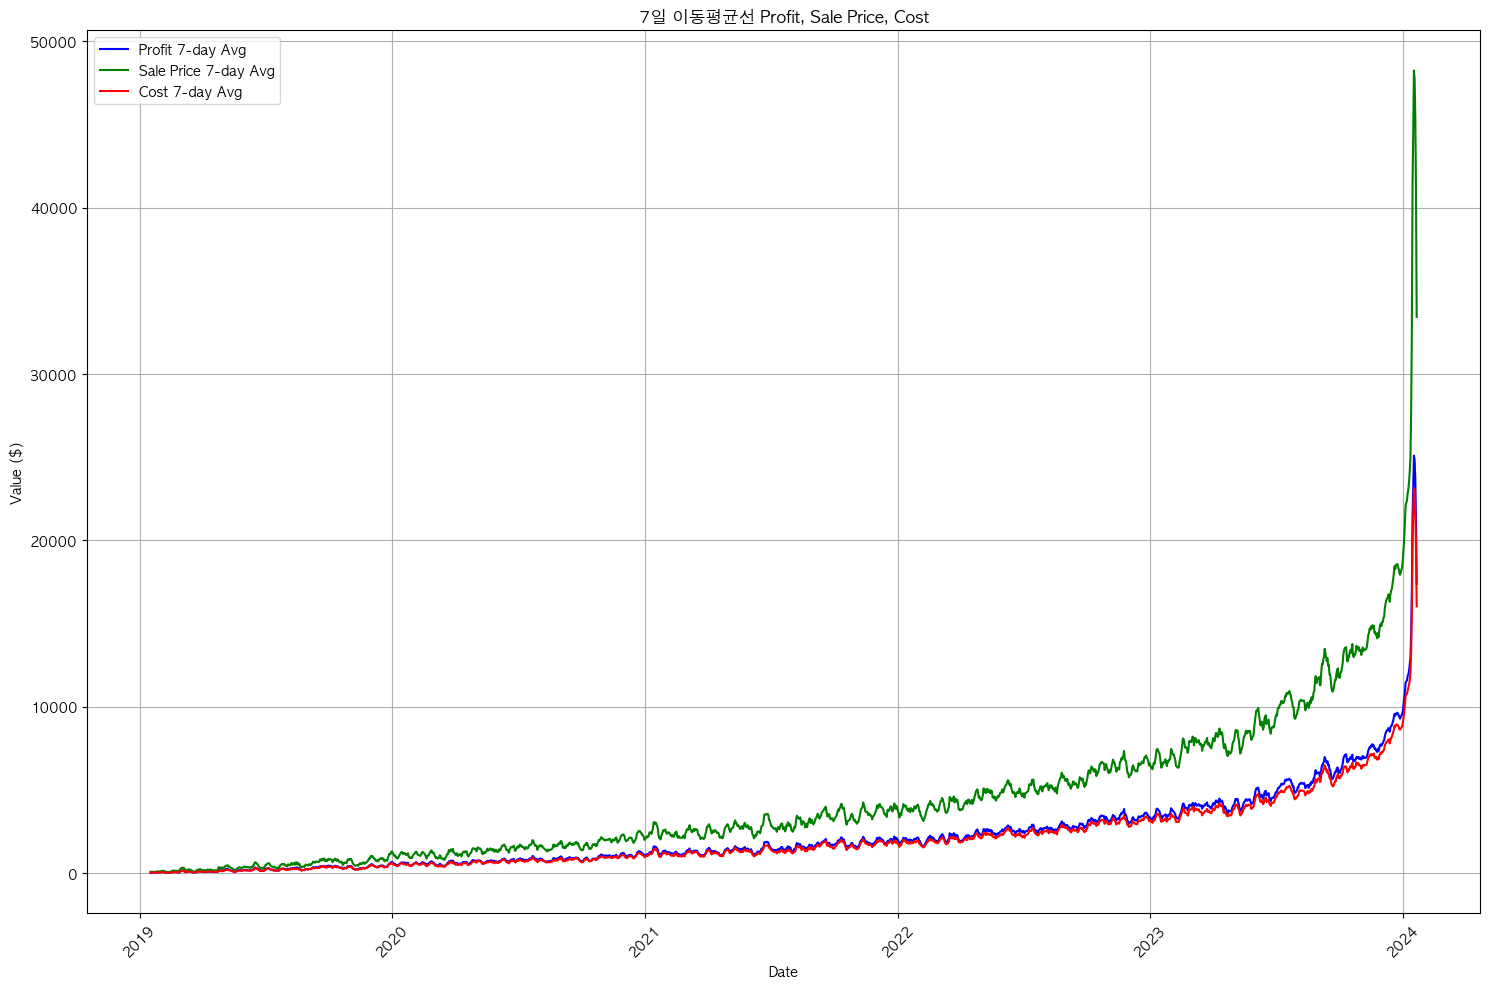

In [46]:
# 연도별 그룹핑
grouped_by_year = orders_complete_merged.groupby(orders_complete_merged['created_at'].dt.date)[['profit', 'sale_price', 'cost']].sum().reset_index()


plt.figure(figsize=(15, 10))

for column in ['profit', 'sale_price', 'cost']:
    grouped_by_year[column+'_7day_avg'] = grouped_by_year[column].rolling(window=7).mean()
grouped_by_year = grouped_by_year.dropna()

# profit
plt.plot(grouped_by_year['created_at'], grouped_by_year['profit_7day_avg'], label='Profit 7-day Avg', color='blue')

# sale price
plt.plot(grouped_by_year['created_at'], grouped_by_year['sale_price_7day_avg'], label='Sale Price 7-day Avg', color='green')

# cost
plt.plot(grouped_by_year['created_at'], grouped_by_year['cost_7day_avg'], label='Cost 7-day Avg', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.title('7일 이동평균선 Profit, Sale Price, Cost')
plt.legend()

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Displaying the plot
plt.grid(True)
plt.tight_layout()
plt.show()


# top 카테고리의 연도별 매출액 추이

In [ ]:
# target_category = 'Outerwear & Coats'
# t1 = orders_complete_merged[orders_complete_merged['category'] == target_category]

# # 연도별 그룹핑
# grouped_by_year_t1 = t1.groupby(orders_complete_merged['created_at'].dt.date)[['profit', 'sale_price', 'cost']].sum().reset_index()


# grouped_by_year_t1['sale_price_7day_avg'] = grouped_by_year_t1['sale_price'].rolling(window=7).mean()
# grouped_by_year = grouped_by_year.dropna()


# plt.figure(figsize=(15, 10))
# plt.plot(grouped_by_year_t1['created_at'], grouped_by_year_t1['sale_price_7day_avg'], label='Sale Price 7-day Avg', color='green')
# # Adding labels and title
# plt.xlabel('Date')
# plt.ylabel('Value ($)')
# plt.title('7일 이동평균선 Profit, Sale Price, Cost')
# plt.legend()
# # Displaying the plot
# plt.grid(True)
# plt.tight_layout()
# plt.show()


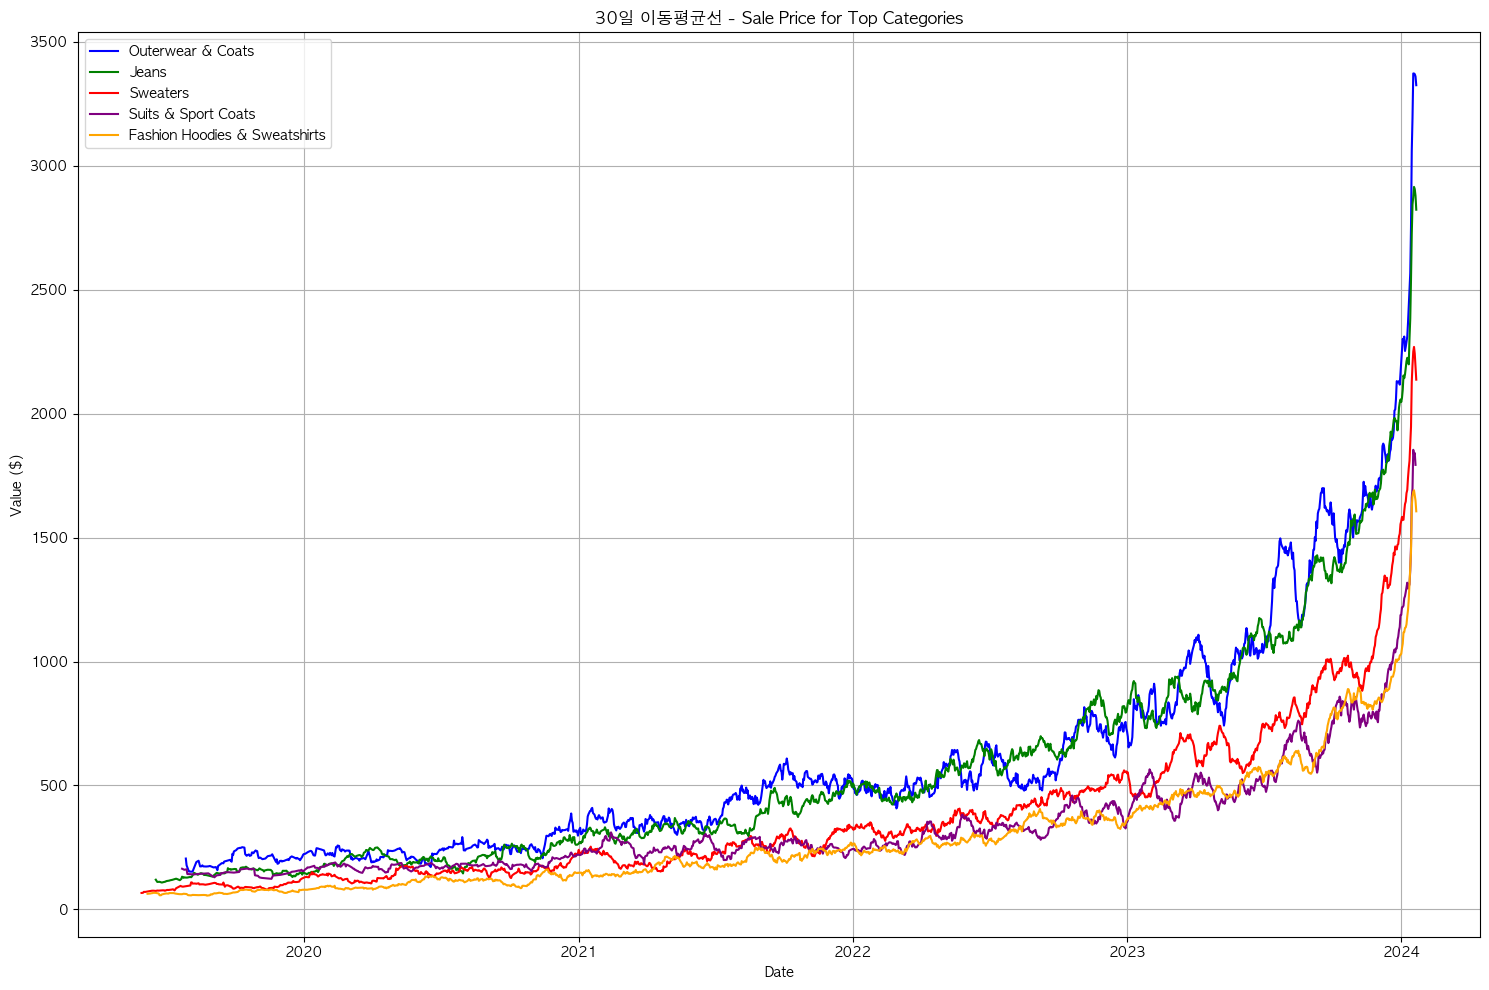

In [71]:
# 색깔 리스트
colors = ['blue', 'green', 'red', 'purple', 'orange']

# 새로운 figure 생성
plt.figure(figsize=(15, 10))

# top_cat_performers 리스트의 각 카테고리에 대해 반복하여 그래프를 그림
for i, target_category in enumerate(top_cat_performers_list):
    t1 = orders_complete_merged[orders_complete_merged['category'] == target_category]

    # 연도별 그룹핑
    grouped_by_year_t1 = t1.groupby(orders_complete_merged['created_at'].dt.date)[['profit', 'sale_price', 'cost']].sum().reset_index()

    # 7일 이동평균 계산
    grouped_by_year_t1['sale_price_7day_avg'] = grouped_by_year_t1['sale_price'].rolling(window=30).mean()
    grouped_by_year_t1 = grouped_by_year_t1.dropna()

    # 그래프 그리기
    plt.plot(grouped_by_year_t1['created_at'], grouped_by_year_t1['sale_price_7day_avg'], label=target_category, color=colors[i])

# 축 레이블과 제목 추가
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.title('30일 이동평균선 - Sale Price for Top Categories')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
